In [1]:
using OrdinaryDiffEq, Sundials, DiffEqDevTools, DiffEqOperators
using LinearAlgebra, SparseArrays
using Plots; gr();

# Burgers equation

The one-dimensional [Burgers equation](https://en.wikipedia.org/wiki/Burgers%27_equation) is a frequently used toy nonlinear PDE model. The defining feature of the equation is its ability to develop discontinuities (shock waves) from continuous initial data.

The continuous Burgers equation is

$$ u_t = \epsilon u_{xx} - uu_x, \quad x\in [0,1], \, t\in [0,1]$$

with Dirichlet boundary conditions and smooth initial data. For numerical discretization, we rewrite the nonlinear term as $-\frac12(u^2)_x$ and use central differencing for the spatial derivatives, which we express as sparse matrices.

To accurately capture the shock in the solution, we need to use a fine mesh. Since the spectral radius of the laplacian grows like $O(N^2)$, the linear term will become very stiff and make it difficult for explicit methods to perform.

TODO: 

* After updates to DiffEqOperators, benchmark again using matrix-free derivative operators.

* Add a section to compare performance with explicit and implicit methods

In [11]:
# Define the linear and nonlinear terms
function lin_term(N, ϵ)
    dx = 1/(N + 1)
    d = -2 * ones(N) # main diagonal
    du = ones(N - 1) # off diagonal
    DiffEqArrayOperator((ϵ/dx^2) * spdiagm(-1 => du, 0 => d, 1 => du))
    # spdiagm is more efficient than BandedMatrix: faster ishermitian and mul!
end

function nl_term(N)
    # Construct a light-weight function object via closure
    dx = 1/(N + 1)
    du = ones(N - 1) # super diagonal
    dl = -ones(N - 1) # lower diagonal
    D = (-1/(4*dx)) * spdiagm(-1 => dl, 1 => du)
    
    tmp = zeros(N)
    function (du,u,p,t)
        @. tmp = u^2
        mul!(du, D, tmp)
    end
end

# Construct the problem
function burgers(N, ϵ)
    f1 = lin_term(N, ϵ)
    f2 = nl_term(N)
    dx = 1 / (N + 1)
    xs = (1:N) * dx
    
    μ0 = 0.3; σ0 = 0.05
    f0 = x -> exp(-(x - μ0)^2 / (2 * σ0^2))
    u0 = f0.(xs)
    prob = SplitODEProblem(f1, f2, u0, (0.0, 1.0))
    xs, prob
end;

Note that we have defined the linear term as a `DiffEqArrayOperator` and the nonlinear term as a reguler `(du,u,p,t)` function. This is because we want to pose the ODE as a semilinear system via `SplitODEProblem`, which could utilize special solvers such as the exponential Runge-Kutta methods. Some IMEX methods can also take advantage of this special structure, while regular split methods can also expect good performance (see [Split ODE Solvers](http://docs.juliadiffeq.org/latest/solvers/split_ode_solve.html) for an overview of these methods).

### Reference solution using `Tsit5`

TODO: better method for this?

In [25]:
xs, prob = burgers(200, 1e-3)
sol = solve(prob, Tsit5(); abstol=1e-14, reltol=1e-14)
test_sol = TestSolution(sol);

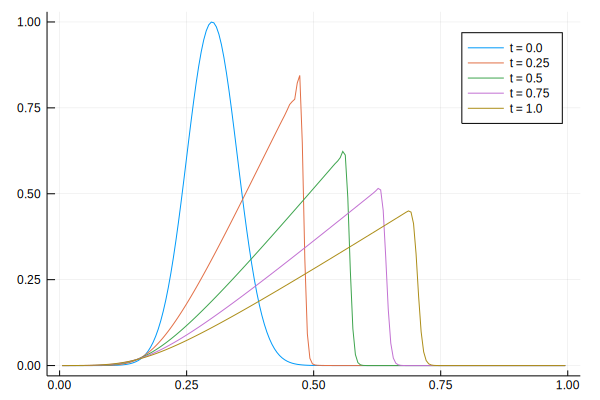

In [26]:
tslices = [0.0 0.25 0.50 0.75 1.00]
ys = hcat(map(t -> sol(t), tslices)...)
labels = map(t -> "t = $t", tslices)
plot(xs, ys, label=labels)

## High tolerances

Testing low order, high tolerance solvers.

TODO: 

* Use either `Rosenbrock23` or `TRBDF2` as a reference. Both errors when applied to the problem; need to transform to regular form?

* Should probably be more careful about error calculation. Need to focus on the resolution of the shock instead of global mean squared error.

* Experiment with varying `iop` in Krylov methods.

In [30]:
abstols = 0.1 .^ (5:8) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (1:4)
multipliers = 0.5 .^ (0:3)
# Note: default linsolve uses lu!, which is incompatible with SparseMatrixCSC
setups = [Dict(:alg => IMEXEuler(linsolve=LinSolveFactorize(lu)), :dts => 1e-3 * multipliers),
          Dict(:alg => CNAB2(linsolve=LinSolveFactorize(lu)), :dts => 5e-3 * multipliers),
          Dict(:alg => CNLF2(linsolve=LinSolveFactorize(lu)), :dts => 5e-3 * multipliers),
          Dict(:alg => SBDF2(linsolve=LinSolveFactorize(lu)), :dts => 1e-3 * multipliers)]
labels = ["IMEXEuler" "CNAB2" "CNLF2" "SBDF2"]
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=1, error_estimate=:final,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

IMEXEuler
CNAB2
CNLF2
SBDF2
 77.663848 seconds (12.78 M allocations: 23.383 GiB, 4.99% gc time)


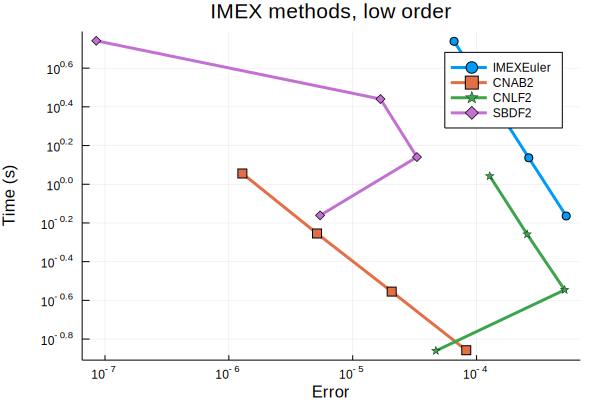

In [38]:
plot(wp, label=labels, markershape=:auto, title="IMEX methods, low order")

In [72]:
abstols = 0.1 .^ (5:8) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (1:4)
multipliers = 0.5 .^ (0:3)
setups = [Dict(:alg => NorsettEuler(), :dts => 1e-3 * multipliers),
          Dict(:alg => NorsettEuler(krylov=true, m=5), :dts => 1e-3 * multipliers),
          Dict(:alg => NorsettEuler(krylov=true, m=20), :dts => 1e-3 * multipliers),
          Dict(:alg => ETDRK2(), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK2(krylov=true, m=5), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK2(krylov=true, m=20), :dts => 1e-2 * multipliers)]
labels = hcat("NorsettEuler (caching)", "NorsettEuler (m=5)", "NorsettEuler (m=20)",
              "ETDRK2 (caching)", "ETDRK2 (m=5)", "ETDRK2 (m=20)")
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=1, error_estimate=:final,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

NorsettEuler (caching)
NorsettEuler (m=5)
NorsettEuler (m=20)
ETDRK2 (caching)
ETDRK2 (m=5)
ETDRK2 (m=20)
 60.936954 seconds (218.61 M allocations: 56.517 GiB, 18.68% gc time)


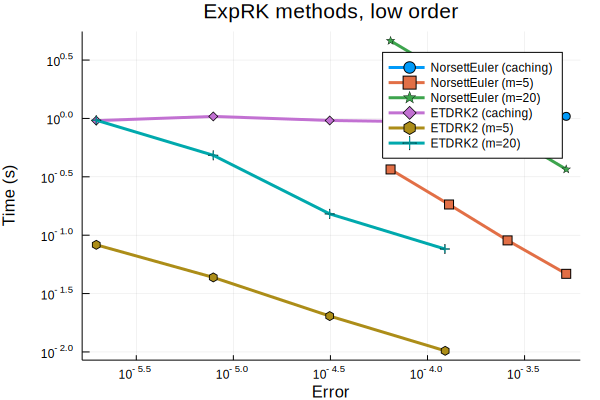

In [73]:
plot(wp, label=labels, markershape=:auto, title="ExpRK methods, low order")

Note that for caching ExpRK methods, the solution time does not vary much with `dt`. This is because most of the time is spent on precomputing the operators rather than actual time stepping.

## Low tolerances

Testing medium order, low tolerance solvers.

In [90]:
@time sol = solve(prob, ARKODE(Sundials.Implicit(), order=5, linear_solver=:GMRES); abstol=1e-7, reltol=1e-4);

  0.054959 seconds (45.51 k allocations: 2.893 MiB)


In [92]:
abstols = 0.1 .^ (7:13)
reltols = 0.1 .^ (4:10)
# Note: default linsolve uses lu!, which is incompatible with SparseMatrixCSC
setups = [Dict(:alg => KenCarp3(linsolve=LinSolveFactorize(lu))),
          Dict(:alg => KenCarp4(linsolve=LinSolveFactorize(lu))),
          Dict(:alg => KenCarp5(linsolve=LinSolveFactorize(lu))),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=3, linear_solver=:GMRES)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=4, linear_solver=:GMRES)),
          Dict(:alg => ARKODE(Sundials.Implicit(), order=5, linear_solver=:GMRES))]
labels = hcat("KenCarp3", "KenCarp4", "KenCarp5", "ARKODE3", "ARKODE4", "ARKODE5")
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=1, error_estimate=:final,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

KenCarp3
KenCarp4
KenCarp5
ARKODE3
ARKODE4
ARKODE5
137.517098 seconds (2.88 G allocations: 69.742 GiB, 11.37% gc time)


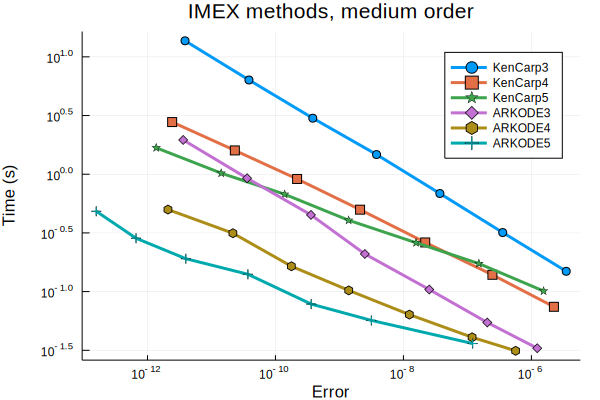

In [93]:
plot(wp, label=labels, markershape=:auto, title="IMEX methods, medium order")

In [110]:
abstols = 0.1 .^ (7:11) # all fixed dt methods so these don't matter much
reltols = 0.1 .^ (4:8)
multipliers = 0.5 .^ (0:4)
setups = [Dict(:alg => ETDRK3(), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK3(krylov=true, m=5), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK4(), :dts => 1e-2 * multipliers),
          Dict(:alg => ETDRK4(krylov=true, m=5), :dts => 1e-2 * multipliers),
          Dict(:alg => HochOst4(), :dts => 1e-2 * multipliers),
          Dict(:alg => HochOst4(krylov=true, m=5), :dts => 1e-2 * multipliers)]
labels = hcat("ETDRK3 (caching)", "ETDRK3 (m=5)", "ETDRK4 (caching)",
              "ETDRK4 (m=5)", "HochOst4 (caching)", "HochOst4 (m=5)")
@time wp = WorkPrecisionSet(prob,abstols,reltols,setups;
                            print_names=true, names=labels,
                            numruns=1, error_estimate=:final,
                            save_everystep=false, appxsol=test_sol, maxiters=Int(1e5));

ETDRK3 (caching)
ETDRK3 (m=5)
ETDRK4 (caching)
ETDRK4 (m=5)
HochOst4 (caching)
HochOst4 (m=5)
110.505817 seconds (94.38 M allocations: 161.452 GiB, 22.09% gc time)


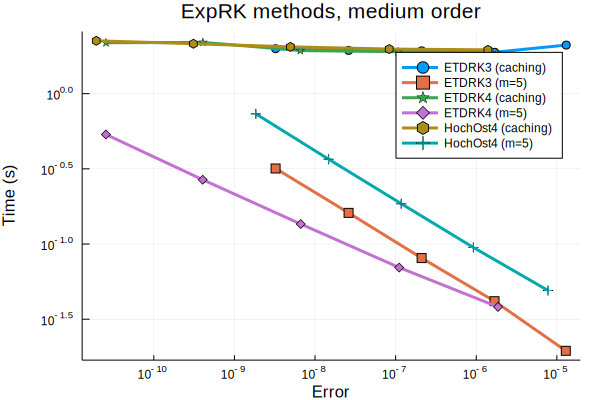

In [111]:
plot(wp, label=labels, markershape=:auto, title="ExpRK methods, medium order")

## EPIRK methods

TODO

## Environment information

In [10]:
versioninfo()
using Pkg
println("OrdinaryDiffEq: ", Pkg.installed()["OrdinaryDiffEq"])
println("Sundials: ", Pkg.installed()["Sundials"])

Julia Version 1.0.1
Commit 0d713926f8 (2018-09-29 19:05 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.0 (ORCJIT, skylake)
OrdinaryDiffEq: 4.15.1+
Sundials: 2.4.1
